In [74]:
import tensorflow as tf
from keras.layers import Dense, LSTM, Conv1D, BatchNormalization, Flatten, Dropout, Activation, Bidirectional, MaxPooling1D, GlobalAveragePooling1D, Add
from keras.models import Model, Sequential
import numpy as np
import pandas as pd
import matplotlib.pyplot as py
import os


In [ ]:

file = open('WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')
lines = file.readlines()
processed_list = []
for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line [5].split(';')[0]
        last = last.strip()
        if last == '':
            break;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processed_list.append(temp)
    except:
        print('Error at line: ',i)
        

In [78]:
columns = ['user', 'activity', 'time', 'x', 'y', 'z']

In [ ]:
data = pd.DataFrame(data = processed_list, columns= columns)
data.head()

In [ ]:
data['activity'].value_counts()

In [82]:
data = data.drop(['user','time'], axis=1)

In [83]:
data.head()

,activity,x,y,z
0,Jogging,-0.6946377,12.680544,0.50395286
1,Jogging,5.012288,11.264028,0.95342433
2,Jogging,4.903325,10.882658,-0.08172209
3,Jogging,-0.61291564,18.496431,3.0237172
4,Jogging,-1.1849703,12.108489,7.205164


### Balancing - all data labels with same no. of entries

### Standarizing the data- to reduce the variance

In [84]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
label = LabelEncoder()
data['label'] = label.fit_transform(data['activity'])
data[2000:]

,activity,x,y,z,label
2000,Downstairs,-0.5720546,9.615966,-0.14982383,0
2001,Downstairs,-1.8387469,6.742072,1.334794,0
2002,Downstairs,2.7649305,7.668256,1.56634,0
2003,Downstairs,-2.4108016,8.689782,4.4810944,0
2004,Downstairs,-2.6832085,10.147159,6.5922484,0
...,...,...,...,...,...
343411,Walking,0.31,10.73,0.040861044,5
343412,Walking,2.76,10.95,0.84446156,5
343413,Walking,0.8,10.15,1.334794,5
343414,Walking,-1.57,8.69,1.4165162,5


In [ ]:
x_train = data[['x', 'y', 'z']]
y_train = data ['label']
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
X_train_sc = pd.DataFrame(data= x_train, columns=['x', 'y', 'z'])
X_train_sc['label'] = y_train.values
X_train_sc


### Windowing


In [87]:
import scipy.stats as stats
window_size = 128
hop_size = 64
def get_window (df, frame_size, hop_size, label):
    N_features = 3
    frame=[]
    labels = []
    for i in range(0, len(X_train_sc)-frame_size, hop_size):
        x = X_train_sc['x'].values[i:i+frame_size]
        y = X_train_sc['y'].values[i:i+frame_size]
        z = X_train_sc['z'].values[i:i+frame_size]

        label = stats.mode(X_train_sc['label'][i:i+frame_size])[0][0] #maximum labels in the window
        frame.append([x,y,z])
        labels.append(label)
    frame = np.asarray(frame).reshape(-1, frame_size, N_features)
    labels = np.asarray(labels)

    return frame, labels


In [88]:
x, y = get_window(X_train_sc, window_size, hop_size, y_train)

In [89]:
from sklearn.model_selection import train_test_split
x_tr, x_test, y_tr, y_test = train_test_split(x, y, random_state=0, stratify= y, test_size = 0.3)
x_tr.shape, x_test.shape

((3754, 128, 3), (1610, 128, 3))

custom model

In [96]:
model = Sequential()
model.add(Conv1D(64, (4), padding= 'same', input_shape = x_tr[0].shape))
model.add(Dropout(0.2))


model.add(Conv1D(128, (4), padding='same', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Conv1D(256, (4), activation= 'relu'))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128, return_sequences= True)))
model.add(Bidirectional(LSTM(64, return_sequences= True)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))



In [97]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_36 (Conv1D)          (None, 128, 64)           832       
                                                                 
 dropout_6 (Dropout)         (None, 128, 64)           0         
                                                                 
 conv1d_37 (Conv1D)          (None, 128, 128)          32896     
                                                                 
 dropout_7 (Dropout)         (None, 128, 128)          0         
                                                                 
 conv1d_38 (Conv1D)          (None, 125, 256)          131328    
                                                                 
 dropout_8 (Dropout)         (None, 125, 256)          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 125, 256)        

In [98]:
model.compile(
            loss = 'sparse_categorical_crossentropy',
            metrics= ['accuracy'],
            optimizer= tf.keras.optimizers.Adamax(learning_rate=0.001)
)

In [99]:
filepath = r'C:\Users\pusha\OneDrive\Documents\housing_pred\HAR_proj\WISDM'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("WISDM_custom.h5", 
                                            monitor = 'val_loss',
                                            save_best_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch'
)

In [ ]:
his = model.fit(
        x_tr, y_tr,
        epochs= 100,
       validation_data= (x_test, y_test),
       callbacks= [model_checkpoint]
)

VGG16


In [101]:
model1 = Sequential()
model1.add(Conv1D(64, (3), padding= 'same', input_shape = x_tr[0].shape, activation = 'elu'))
model1.add(Conv1D(64, (3), padding= 'same', activation = 'elu'))
model1.add(MaxPooling1D(pool_size=4, strides=2))
model1.add(Conv1D(128, (3), padding = 'same', activation = 'elu'))
model1.add(Conv1D(128, (3), padding = 'same', activation = 'elu'))
model1.add(MaxPooling1D(pool_size=4, strides=2))
model1.add(Conv1D(256, (3), padding = 'same', activation = 'elu'))
model1.add(Conv1D(256, (3), padding = 'same', activation = 'elu'))
model1.add(Conv1D(256, (3), padding = 'same', activation = 'elu'))
model1.add(MaxPooling1D(pool_size=4, strides=2))
model1.add(Conv1D(512, (3), padding = 'same', activation = 'elu'))
model1.add(Conv1D(512, (3), padding = 'same', activation = 'elu'))
model1.add(Conv1D(512, (3), padding = 'same', activation = 'elu'))
model1.add(MaxPooling1D(pool_size=4, strides=2))
model1.add(Flatten())
model1.add(Dense(256, activation='elu'))
model1.add(Dense(128, activation='elu'))
model1.add(Dense(6, activation='softmax'))

In [102]:
model1.compile(
            loss = 'sparse_categorical_crossentropy',
            metrics= ['accuracy'],
            optimizer= tf.keras.optimizers.Adamax(learning_rate=0.000446)
)

In [103]:
filepath = r'C:\Users\pusha\OneDrive\Documents\housing_pred\HAR_proj\WISDM'
model_checkpoint_1 = tf.keras.callbacks.ModelCheckpoint("WISDM_VGG16.h5", 
                                            monitor = 'val_loss',
                                            save_best_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch'
)

In [ ]:
his1 = model1.fit(
        x_tr, y_tr,
        epochs= 100,
       validation_data= (x_test, y_test),
       callbacks= [model_checkpoint_1]
)

RESNET18

In [105]:
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3)
        
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv1D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", activation= 'elu')
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv1D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", activation= 'elu')
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            
            self.res_conv = Conv1D(
                self.__channels, strides=2, kernel_size=(1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv1D(64, (7), strides=2,
                             padding="same", kernel_initializer="he_normal", input_shape = x_tr[0].shape)
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPooling1D(pool_size=(2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling1D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [106]:
model2 = ResNet18(6)

In [107]:
model2.compile(
            loss = 'sparse_categorical_crossentropy',
            metrics= ['accuracy'],
            optimizer= tf.keras.optimizers.Adamax()
)

In [ ]:
his2 = model2.fit(
        x_tr,y_tr,
        epochs= 100,
       validation_data= (x_test, y_test)
       
)

In [ ]:
model2.save('res')

In [110]:
pred_cust = model.predict(x_test)

51/51 [==============================] - 2s 25ms/step


In [ ]:

preds_c = tf.nn.softmax(pred_cust)
pred_vgg = tf.nn.softmax(model1.predict(x_test))
pred_res = tf.nn.softmax(model2.predict(x_test))

In [115]:
pred_lbl = []
for i in range (0, len(preds_c)):
    pred_lbl.append(np.argmax(pred_cust[i]))

In [116]:
pred_lbl = np.array(pred_lbl).reshape(-1)

In [120]:
pred_lbl_1 = []
for i in range (0, len(model1.predict(x_test))):
    pred_lbl_1.append(np.argmax(pred_vgg[i]))

51/51 [==============================] - 0s 3ms/step


In [121]:
pred_lbl_1 = np.array(pred_lbl_1).reshape(-1)

In [122]:
pred_lbl_2 = []
for rows in pred_res:
    pred_lbl_2.append(np.argmax(rows))
pred_lbl_2 = np.array(pred_lbl_2).reshape(-1)

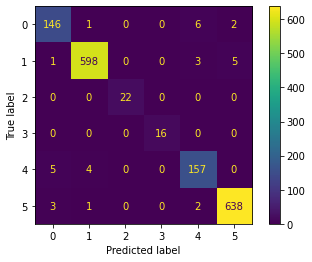

In [123]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, pred_lbl)
plt.show()

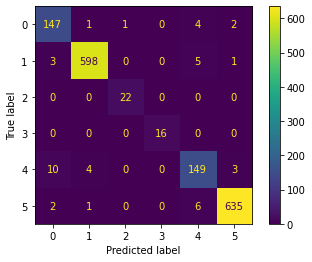

In [124]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_lbl_1)
plt.show()

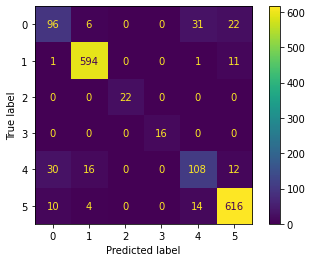

In [125]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_lbl_2)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred_lbl))
print(accuracy_score(y_test, pred_lbl_1))
print(accuracy_score(y_test, pred_lbl_2))

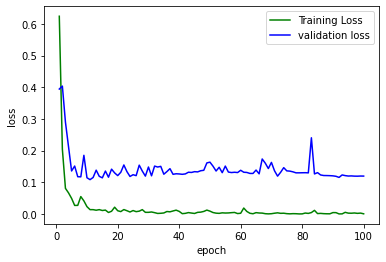

In [168]:
loss_train = his2.history['loss']
loss_val = his.history['val_loss']
epochs = range(1,101)
plt.plot(epochs, loss_train, 'g',label= 'Training Loss' )
plt.plot(epochs, loss_val, 'b', label= 'validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

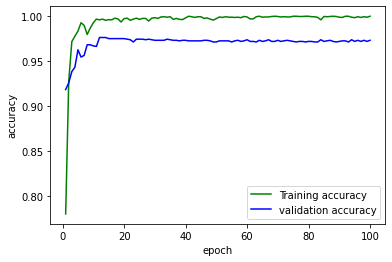

In [170]:
acc_train = his2.history['accuracy']
acc_val = his1.history['val_accuracy']
epochs = range(1,101)
plt.plot(epochs, acc_train, 'g',label= 'Training accuracy' )
plt.plot(epochs, acc_val, 'b', label= 'validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [131]:
from sklearn.metrics import accuracy_score

WEIGHTED MEAN

In [ ]:

pred_1 = []
pred_2 = []
pred_3= []

'''preds_c, pred_vgg, pred_res stores the confidence scores of respective models'''

for rows in range(0,len(preds_c)): 
    pred_1.append(np.argmax(preds_c[rows]))
for rows_1 in pred_res:
    pred_2.append(np.argmax(rows_1))
for rows_2 in pred_vgg:
    pred_3.append(np.argmax(rows_2))


accuracy_1 = accuracy_score(y_test, pred_1)
accuracy_2 = accuracy_score(y_test, pred_2)
accuracy_3 = accuracy_score(y_test, pred_3)
accuracy_1, accuracy_2, accuracy_3

In [151]:
acc_model = [accuracy_1, accuracy_2, accuracy_3]
weights = np.tanh(acc_model)

In [152]:
lent = len(preds_c)
col = len(preds_c[0])
ens_pred_w = np.empty((1610,6), dtype = object)

for i in range (0,lent):
    for j in range (0,col):
        ens_pred_w[i][j] = (weights[0]*preds_c[i][j] + weights[1]*pred_res[i][j] + weights[2]*pred_vgg[i][j])/np.sum(weights)

In [153]:
ens_pred_w

array([[0.12956251204013824, 0.35218739509582525, 0.12956251204013824,
        0.12956251204013824, 0.12956251204013824, 0.12956251204013824],
       [0.12956251204013824, 0.12956251204013824, 0.12956251204013824,
        0.12956251204013824, 0.12956251204013824, 0.35218739509582525],
       [0.12957261579351093, 0.12956807656557837, 0.12956824985529797,
        0.12956836538177768, 0.12958778345757827, 0.35213487868358323],
       ...,
       [0.12958162204532622, 0.12956823060088468, 0.12956853867149726,
        0.12956850978987733, 0.12957980250327053, 0.35213326131286704],
       [0.28016831358207694, 0.12959261144184972, 0.12958007200519614,
        0.12958402397352342, 0.20149510054771352, 0.1295799035290799],
       [0.1295625216673449, 0.12956251685374157, 0.12956251685374157,
        0.12956251685374157, 0.12956251685374157, 0.35218739509582525]],
      dtype=object)

In [154]:
ens_lbl_w = []
t = []
for rows in ens_pred_w:
    ens_lbl_w.append(np.argmax(rows))

In [155]:
ens_accuracy = accuracy_score(y_test, ens_lbl_w)
ens_accuracy

0.9782608695652174

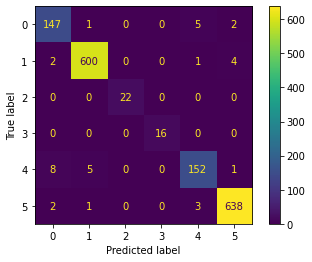

In [158]:
ConfusionMatrixDisplay.from_predictions(y_test, ens_lbl_w)
plt.show()